## TP PDS - Emotion Recognition ##
##### Vitor Oliveira 13062
##### João Faria 14861
##### Helena Correia 14889

### Importação das bibliotecas ###

In [1]:
from scipy.io.wavfile import read
from scipy import signal
from scipy.signal import lfilter, firwin, freqz
from scipy.fftpack import fft,fftfreq 

import librosa
import librosa.display

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from tqdm import tqdm

import sys
import warnings
warnings.filterwarnings('ignore')

# extrair dataset
import os
import glob

# codificação dos labels
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

# PCA/LDA
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# SVM 
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Rede neuronal
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.python.keras import Input
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.losses import CategoricalCrossentropy

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Extração do dataset ###

In [2]:
path = "SER/"
files = os.listdir(path)

# frequência de amostragem do dataset
sr = 22050

sound_data, sound_name, sound_speaker, sound_word, sound_emotion = [], [], [], [], []
c = 0
for filename in tqdm(glob.glob(os.path.join(path, '*.wav'))):
    y, sr = librosa.load(filename)
    sound_data.append(y)
    sound_name.append(filename)
    
    # separar o texto do audio por utilizador/palavra/emoção
    person = filename.split('_')[0]
    sound_speaker.append(person.split('\\', 1)[1])
    sound_word.append(filename.split('_')[1])
    emotion = filename.split('_')[2]
    sound_emotion.append(emotion.split('.', 1)[0])
    
    c = c + 1

100%|██████████████████████████████████████████████████████████████████████████████| 2800/2800 [01:53<00:00, 24.60it/s]


### Colocar o dataset numa dataframe ###

In [3]:
df = pd.DataFrame(
    {'sound_name': sound_name,
     'sound_raw_data': sound_data,
     'sound_speaker': sound_speaker,
     'sound_word': sound_word,
     'sound_emotion': sound_emotion
    })

df.head()

sound_name  \
0    SER\OAF_back_angry.wav   
1  SER\OAF_back_disgust.wav   
2     SER\OAF_back_fear.wav   
3    SER\OAF_back_happy.wav   
4  SER\OAF_back_neutral.wav   

                                      sound_raw_data sound_speaker sound_word  \
0  [-1.0417719e-05, -0.00019059131, -0.0002863014...           OAF       back   
1  [4.994996e-06, -3.9724873e-05, 3.148689e-05, 7...           OAF       back   
2  [-2.8841856e-07, -0.00010423521, -0.0001048797...           OAF       back   
3  [9.551983e-05, -0.0013329886, -0.0025686934, -...           OAF       back   
4  [-3.4720515e-06, 4.0753355e-05, 5.3738426e-05,...           OAF       back   

  sound_emotion  
0         angry  
1       disgust  
2          fear  
3         happy  
4       neutral

#### Limpar variaveis ####

In [4]:
del sound_data
del sound_name
del sound_speaker
del sound_word
del sound_emotion

### Distribuição das classes de emoção no dataset ###

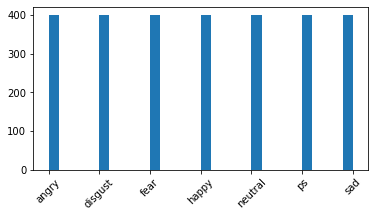

In [5]:
plt.rcParams['figure.figsize'] = [6, 3]
ax = plt.subplot(111)
ax.hist(df['sound_emotion'], bins=30)
ax.set_xticklabels(pd.unique(df['sound_emotion']), rotation=45)
print("")

### Recolha dos indices de 3 palavras (back, knock e join) dos 2 utilizadores (OAF, YAF) das 7 emoções do dataset para estudo de PDS ###

In [6]:
angry_idx, disgust_idx, fear_idx, happy_idx, neutral_idx, ps_idx, sad_idx = [], [], [], [], [], [], []

for i in range(len(df)):
    # angry
    if 'angry' in df['sound_emotion'][i] and 'OAF' in df['sound_speaker'][i]:
        if 'back' in df['sound_word'][i] or 'join' in df['sound_word'][i] \
        or 'knock' in df['sound_word'][i]:
            angry_idx.append(i)
    elif 'angry' in df['sound_emotion'][i] and 'YAF' in df['sound_speaker'][i]:
        if 'back' in df['sound_word'][i] or 'join' in df['sound_word'][i] \
        or 'knock' in df['sound_word'][i]:
            angry_idx.append(i)
            
    # disgust       
    elif 'disgust' in df['sound_emotion'][i] and 'OAF' in df['sound_speaker'][i]:
        if 'back' in df['sound_word'][i] or 'join' in df['sound_word'][i] \
        or 'knock' in df['sound_word'][i]:
            disgust_idx.append(i)
    elif 'disgust' in df['sound_emotion'][i] and 'YAF' in df['sound_speaker'][i]:
        if 'back' in df['sound_word'][i] or 'join' in df['sound_word'][i] \
        or 'knock' in df['sound_word'][i]:
            disgust_idx.append(i)
            
    # fear
    elif 'fear' in df['sound_emotion'][i] and 'OAF' in df['sound_speaker'][i]:
        if 'back' in df['sound_word'][i] or 'join' in df['sound_word'][i] \
        or 'knock' in df['sound_word'][i]:
            fear_idx.append(i)
    elif 'fear' in df['sound_emotion'][i] and 'YAF' in df['sound_speaker'][i]:
        if 'back' in df['sound_word'][i] or 'join' in df['sound_word'][i] \
        or 'knock' in df['sound_word'][i]:
            fear_idx.append(i)
            
    # happy
    elif 'happy' in df['sound_emotion'][i] and 'OAF' in df['sound_speaker'][i]:
        if 'back' in df['sound_word'][i] or 'join' in df['sound_word'][i] \
        or 'knock' in df['sound_word'][i]:
            happy_idx.append(i)
    elif 'happy' in df['sound_emotion'][i] and 'YAF' in df['sound_speaker'][i]:
        if 'back' in df['sound_word'][i] or 'join' in df['sound_word'][i] \
        or 'knock' in df['sound_word'][i]:
            happy_idx.append(i)
            
    # neutral
    elif 'neutral' in df['sound_emotion'][i] and 'OAF' in df['sound_speaker'][i]:
        if 'back' in df['sound_word'][i] or 'join' in df['sound_word'][i] \
        or 'knock' in df['sound_word'][i]:
            neutral_idx.append(i)
    elif 'neutral' in df['sound_emotion'][i] and 'YAF' in df['sound_speaker'][i]:
        if 'back' in df['sound_word'][i] or 'join' in df['sound_word'][i] \
        or 'knock' in df['sound_word'][i]:
            neutral_idx.append(i)
            
    # ps
    elif 'ps' in df['sound_emotion'][i] and 'OAF' in df['sound_speaker'][i]:
        if 'back' in df['sound_word'][i] or 'join' in df['sound_word'][i] \
        or 'knock' in df['sound_word'][i]:
            ps_idx.append(i)
    elif 'ps' in df['sound_emotion'][i] and 'YAF' in df['sound_speaker'][i]:
        if 'back' in df['sound_word'][i] or 'join' in df['sound_word'][i] \
        or 'knock' in df['sound_word'][i]:
            ps_idx.append(i)
            
    # sad
    elif 'sad' in df['sound_emotion'][i] and 'OAF' in df['sound_speaker'][i]:
        if 'back' in df['sound_word'][i] or 'join' in df['sound_word'][i] \
        or 'knock' in df['sound_word'][i]:
            sad_idx.append(i)
    elif 'sad' in df['sound_emotion'][i] and 'YAF' in df['sound_speaker'][i]:
        if 'back' in df['sound_word'][i] or 'join' in df['sound_word'][i] \
        or 'knock' in df['sound_word'][i]:
            sad_idx.append(i)

# juntar os indices todos 
emt_idx_all = angry_idx + disgust_idx + fear_idx + happy_idx + neutral_idx + ps_idx + sad_idx 

### Gráfico de tempo dos áudios com os indices anteriores ###

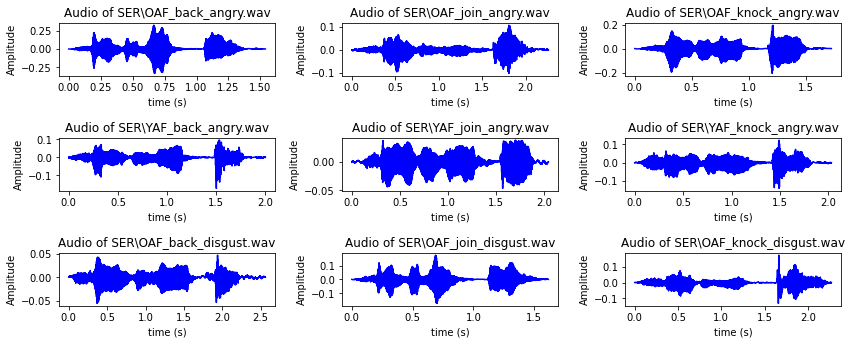

In [7]:
plt.rcParams['figure.figsize'] = [12, 5]

for i in range(9):
    plt.subplot(3,3,i+1)
    
    t = len(df['sound_raw_data'][i])/sr
    t1 = np.linspace(0, t, len(df['sound_raw_data'][i]))
    
    plt.plot(t1, df['sound_raw_data'][i],'b')
    plt.title('Audio of ' + df['sound_name'][emt_idx_all[i]])
    plt.xlabel("time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout(pad=1.5)

### 1º Abordagem: Filtrar os áudios entre 20-3600Hz (frequências vocais) ###

Text(0, 0.5, 'dB')

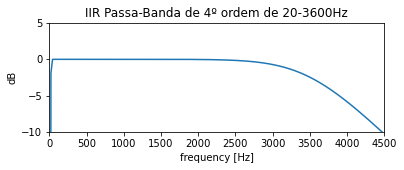

In [8]:
# Frequência de Nyquist
nyq_rate = sr / 2.0

# Frequência de corte do filtro
cutoff_hz = [20/nyq_rate, 3600/nyq_rate]

# Ordem do filtro 
N = 4

b, a = signal.butter(N, cutoff_hz, 'bandpass') 
w, h = signal.freqz(b, a)

plt.rcParams['figure.figsize'] = [6, 2]

plt.plot(sr * w/(2 * np.pi), 20 * np.log10(abs(h)))
plt.title('IIR Passa-Banda de 4º ordem de 20-3600Hz')
plt.xlim([0, 4500])
plt.ylim([-10, 5])
plt.xlabel('frequency [Hz]')
plt.ylabel('dB')

#### Filtrar todos os sons com o filtro ####

In [59]:
filtered_sounds = []
for i in tqdm(range(len(df)), position=0, leave=True):
    filtered = signal.filtfilt(b, a, df['sound_raw_data'][i])
    filtered_sounds.append(filtered)

    
if 'sound_filtered' in df:
    print("WARNING!")
    df = df.drop(['sound_filtered'], axis=1)

    
df.insert(2, "sound_filtered", filtered_sounds, True)  

100%|████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 397.62it/s]


WARNING!


### Análise dos MFCCs para as 7 emoções usando o filtro de 20-3600Hz ###

100%|█████████████████████████████████████████████████████████████████████| 42/42 [00:09<00:00,  4.42it/s]


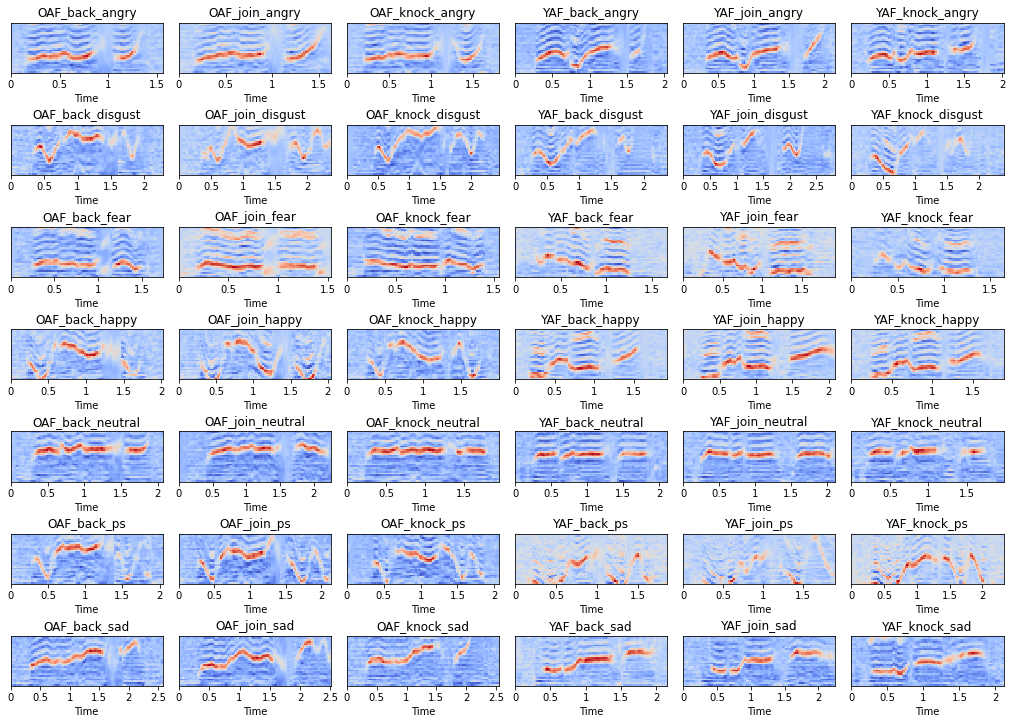

In [60]:
plt.rcParams['figure.figsize'] = [14, 10]

for i in tqdm(range(len(emt_idx_all))):
    mfccs = librosa.feature.mfcc(df['sound_filtered'][emt_idx_all[i]], sr, n_mfcc=40, fmax=sr//4)
    plt.subplot(7,6,i+1)
    mfccs_line = mfccs[12:40, :]
    img = librosa.display.specshow(mfccs_line, x_axis='time')
    plt.title(df['sound_name'][emt_idx_all[i]].split('\\')[1].split('.')[0])
    plt.tight_layout(pad=0.5)

#### Observação: Visualmente as diferentes emoções começam a ter um padrão similar independentemente da palavra, no entanto difere entre os dois utilizadores. Adicionalmente, o padrão emocional não se encontra totalmente destacado na imagem apresentando ruído.

### 2º Abordagem: Filtrar os áudios entre 60-600Hz (frequências principais das emoções deste dataset) ###

<table><tr>
<td> <img src="emotional_frequency_chart.png" style="width: 412px;"/> </td>
<td> <img src="valence_chart_article.png" style="width: 420px;"/> </td>
</tr></table>

##### Right Image Source: R. Yuvaraj et al., “On the analysis of EEG power, frequency and asymmetry in Parkinson’s disease during emotion processing,” Behav. Brain Funct., 2014, doi: 10.1186/1744-9081-10-12.

Text(0, 0.5, 'dB')

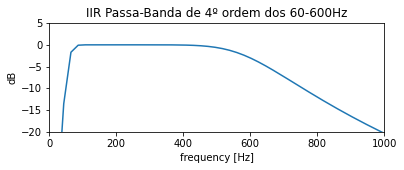

In [9]:
# frequência de nyquist
nyq_rate = sr / 2.0

# Frequência de corte do filtro
cutoff_hz = [60/nyq_rate, 600/nyq_rate]

# Ordem do filtro
N = 4

b, a = signal.butter(N, cutoff_hz, 'bandpass') 
w, h = signal.freqz(b, a)

plt.rcParams['figure.figsize'] = [6, 2]

plt.plot(sr * w/(2 * np.pi), 20 * np.log10(abs(h)))
plt.title('IIR Passa-Banda de 4º ordem dos 60-600Hz')
plt.xlim([0, 1000])
plt.ylim([-20, 5])
plt.xlabel('frequency [Hz]')
plt.ylabel('dB')

#### Aplicar o filtro a todos os áudios ####

In [10]:
filtered_sounds = []
for i in tqdm(range(len(df)), position=0, leave=True):
    filtered = signal.filtfilt(b, a, df['sound_raw_data'][i])
    filtered_sounds.append(filtered)

    
if 'sound_filtered' in df:
    print("WARNING!")
    df = df.drop(['sound_filtered'], axis=1)

    
df.insert(2, "sound_filtered", filtered_sounds, True)   

100%|███████████████████████████████████████████████████| 2800/2800 [00:03<00:00, 754.81it/s]


#### Visualizar o filtro num áudio ####

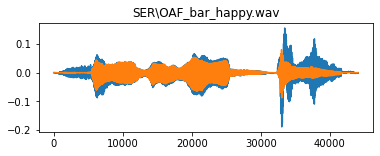

In [24]:
ii = 10
plt.rcParams['figure.figsize'] = [6, 2]
plt.plot(df['sound_raw_data'][ii])
plt.plot(df['sound_filtered'][ii])
plt.title(df['sound_name'][ii])
print("")

### Análise dos MFCCs para diferentes emoções usando o filtro de 60-600Hz ###

100%|██████████████████████████████████████████████████████████████| 42/42 [00:08<00:00,  5.12it/s]


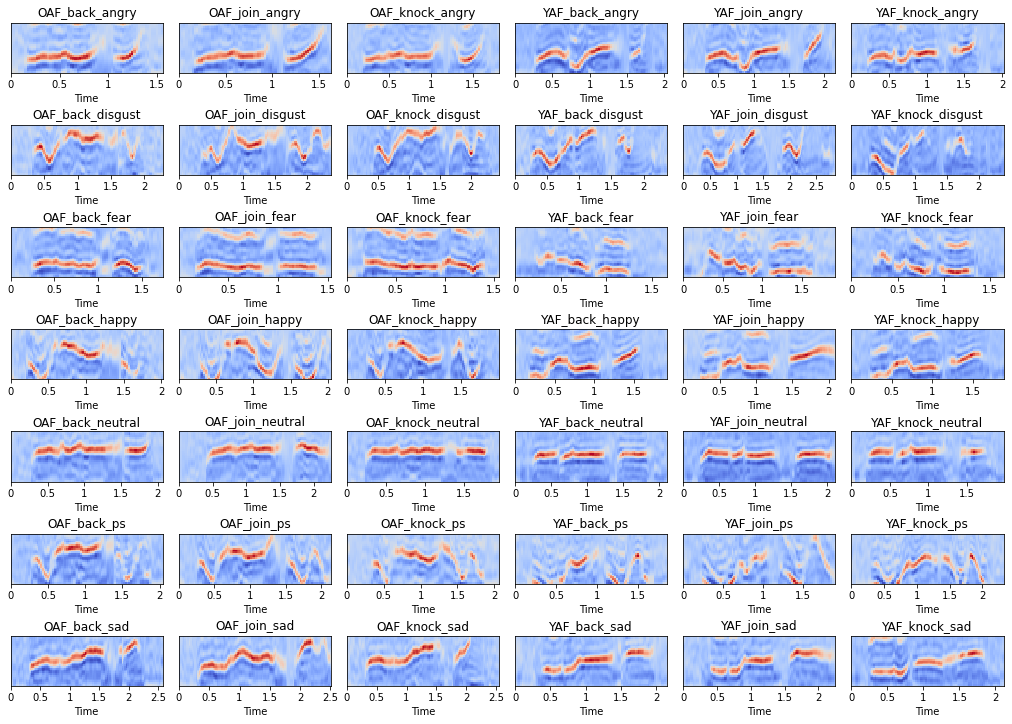

In [27]:
plt.rcParams['figure.figsize'] = [14, 10]

for i in tqdm(range(len(emt_idx_all))):
    mfccs = librosa.feature.mfcc(df['sound_filtered'][emt_idx_all[i]], sr, n_mfcc=40, fmax=sr//4)
    plt.subplot(7,6,i+1)
    mfccs_line = mfccs[12:40, :]
    img = librosa.display.specshow(mfccs_line, x_axis='time')
    plt.title(df['sound_name'][emt_idx_all[i]].split('\\')[1].split('.')[0])
    plt.tight_layout(pad=0.5)

#### Observação: Neste caso as emoções têm claramente um padrão similar independentemente da palavra ou utilizador. Por isso  considera-se este filtro adequado.

### FFT dos áudios filtrados ###

100%|██████████████████████████████████████████████████████████████| 42/42 [00:09<00:00,  4.59it/s]


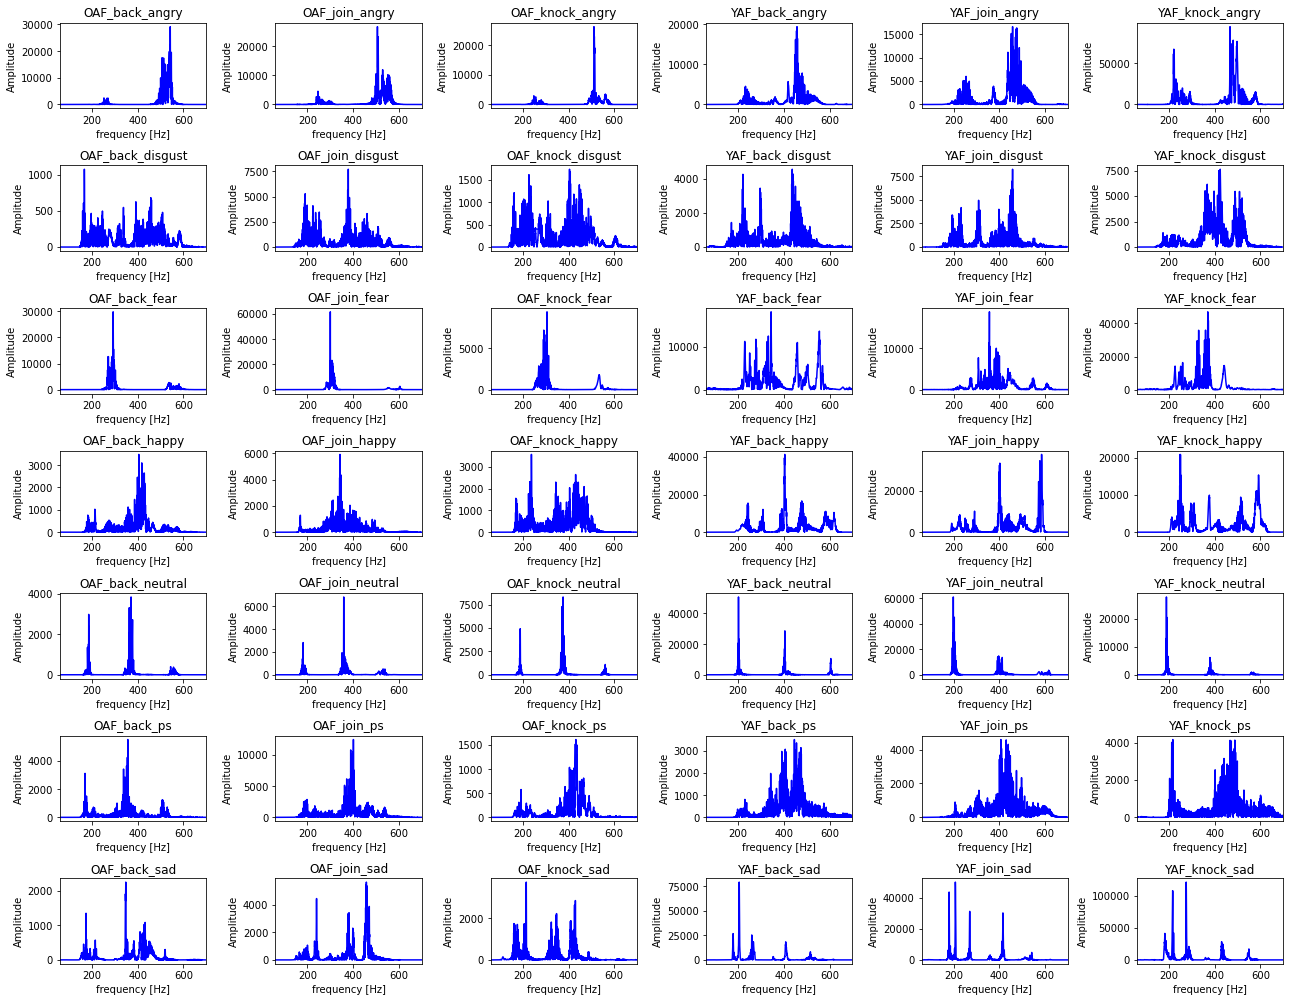

In [29]:
plt.rcParams['figure.figsize'] = [18, 14]

num_fft = 1024

for i in tqdm(range(len(emt_idx_all))):
    FFT = abs(fft(df['sound_filtered'][emt_idx_all[i]]))
    
    sound_time = len(df['sound_filtered'][emt_idx_all[i]]) / sr
    n_samples = len(df['sound_filtered'][emt_idx_all[i]])
    t = np.linspace(0, sound_time, n_samples)

    # diferença temporal (resolução)
    time_step = t[1]-t[0]

    freqs = fftfreq(n_samples, time_step)
    pos_freqs = np.argwhere(freqs>=0)
    
    plt.subplot(7,6,i+1)
    plt.plot(freqs[pos_freqs],FFT[pos_freqs]**2,'b')
    plt.title(df['sound_name'][emt_idx_all[i]].split('\\')[1].split('.')[0])
    plt.xlabel('frequency [Hz]')
    plt.ylabel('Amplitude')
    plt.xlim([60, 700])
    plt.tight_layout(pad=1.0)

#### Observação: A FFT indica as frequências mais relevantes de cada emoção visto que o áudio está filtrado para isso. Verifica-se que nas diferentes emoções as frequências mais relevantes encontram-se nos 200Hz, 400Hz e 600Hz.

### Periodograma de Welch dos áudios filtrados ###

100%|██████████████████████████████████████████████████████████████| 42/42 [00:09<00:00,  4.36it/s]


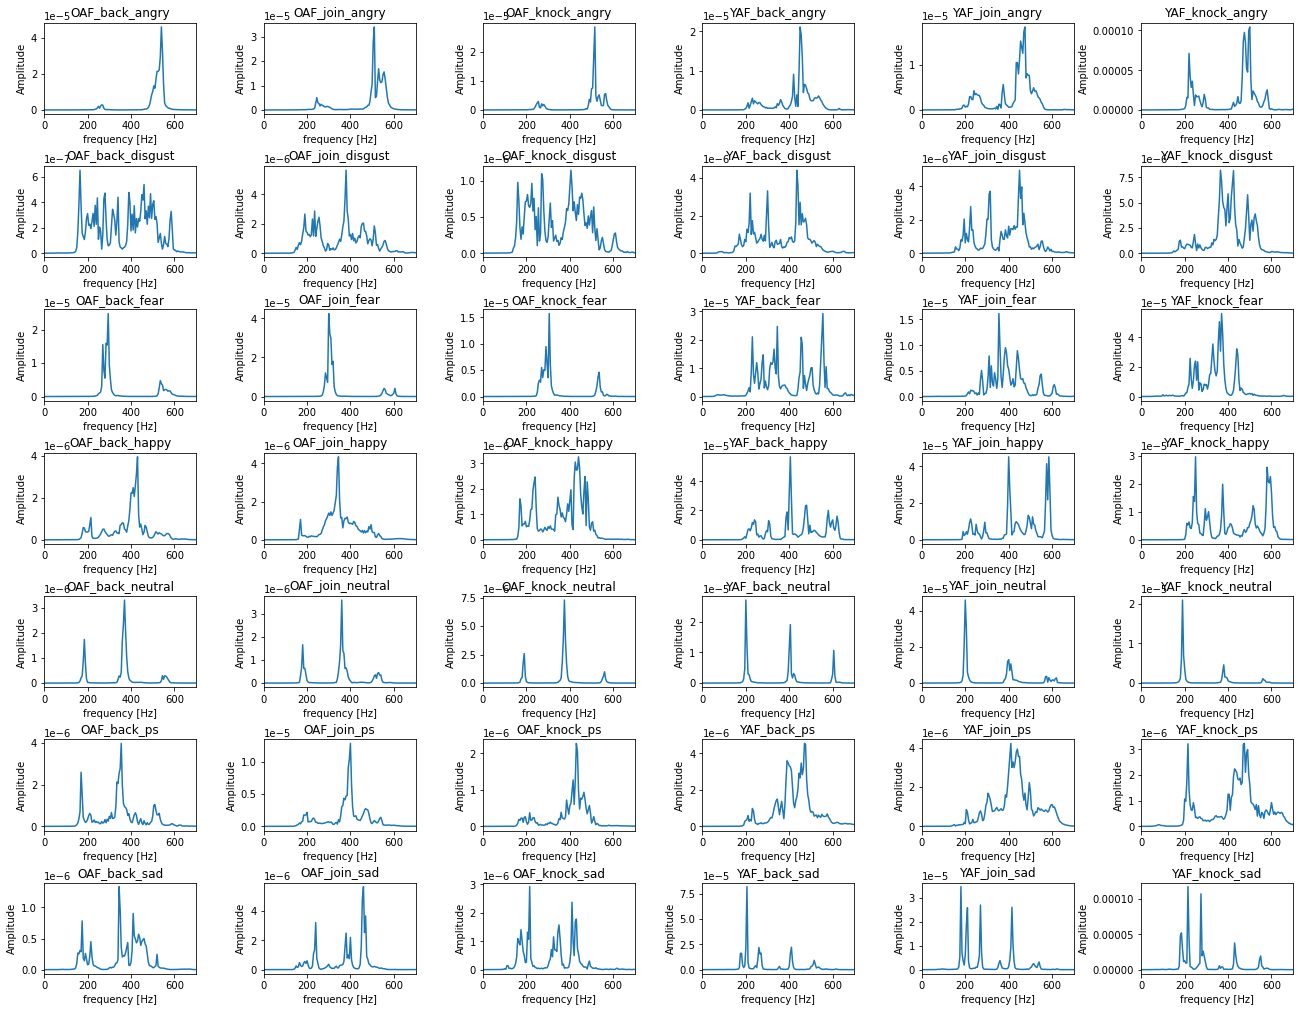

In [33]:
plt.rcParams['figure.figsize'] = [18, 14]

win = sr * 0.2

for i in tqdm(range(len(emt_idx_all))):
    f, Pxx_spec = signal.welch(df['sound_filtered'][emt_idx_all[i]], sr, 
                               'boxcar', nperseg=win, noverlap=win//2, scaling='density')
    
    plt.subplot(7,6,i+1)
    plt.plot(f, Pxx_spec)
    plt.title(df['sound_name'][emt_idx_all[i]].split('\\')[1].split('.')[0])
    plt.xlabel('frequency [Hz]')
    plt.ylabel('Amplitude')
    plt.xlim([0, 700])
    plt.tight_layout(pad=0.5)

#### Observação: O periodograma de welch permitiu suavizar o padrão da FFT e realçar algumas frequências escondidas entre os 200 e 600 Hz.  

### STFT (Espectograma) dos áudios filtrados ###

100%|██████████████████████████████████████████████████████████████| 42/42 [00:09<00:00,  4.58it/s]


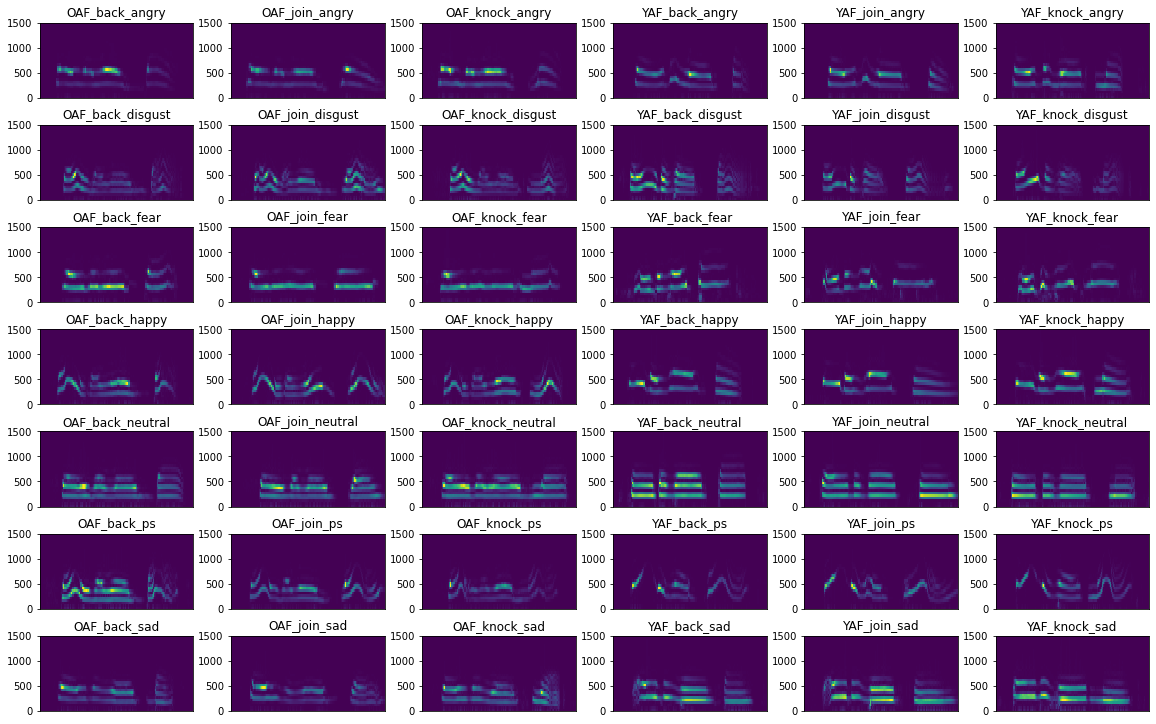

In [36]:
plt.rcParams['figure.figsize'] = [16, 10]

fig, axs = plt.subplots(7, 6)

m = [[0,0], [0,1], [0,2], [0,3], [0,4], [0,5], 
     [1,0], [1,1], [1,2], [1,3], [1,4], [1,5], 
     [2,0], [2,1], [2,2], [2,3], [2,4], [2,5], 
     [3,0], [3,1], [3,2], [3,3], [3,4], [3,5], 
     [4,0], [4,1], [4,2], [4,3], [4,4], [4,5],
     [5,0], [5,1], [5,2], [5,3], [5,4], [5,5],  
     [6,0], [6,1], [6,2], [6,3], [6,4], [6,5],
    ]

win = int(sr * 0.02)

for i in tqdm(range(len(emt_idx_all))):    
    f, t, S1 = signal.spectrogram(df['sound_filtered'][emt_idx_all[i]], sr, nperseg=win, noverlap=win//4, 
                                  window='hamming', scaling='spectrum', mode='magnitude')
    
    ax = axs[m[i][0], m[i][1]]
    c = ax.pcolor(t, f[:300], S1[:300][:])
    ax.set_title(df['sound_name'][emt_idx_all[i]].split('\\')[1].split('.')[0])
    ax.set_ylim([0, 1500])
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    
fig.tight_layout(pad=0.5)

#### Observação: Tal como na análise dos MFCC, o espectograma mostra um padrão similar da emoção independentemente da palavra e utilizador o que indica que poderá ser uma feature adequada para distinguir as emoções.

### BPM & Zero Crossing dos áudios analisados ###

In [35]:
bpm, zero_crossings, emotion = [], [], []
for i in tqdm(range(len(df))):
    tempo = librosa.beat.tempo(df['sound_filtered'][i])[0]
    bpm.append(tempo.round(2))
    
    zc = sum(librosa.zero_crossings(df['sound_filtered'][i], pad=False))
    zero_crossings.append(zc)
    
    emotion.append(df['sound_emotion'][i])

# get the mean bpm of all emotions
df_bpm_zc = pd.DataFrame({'bpm': bpm, 'zc': zero_crossings, 'emotion': emotion})
df_mean_bpm = df_bpm_zc.groupby('emotion', as_index=False)['bpm'].mean()
df_mean_zc = df_bpm_zc.groupby('emotion', as_index=False)['zc'].mean()

100%|██████████████████████████████████████████████████████████| 2800/2800 [07:39<00:00,  6.10it/s]


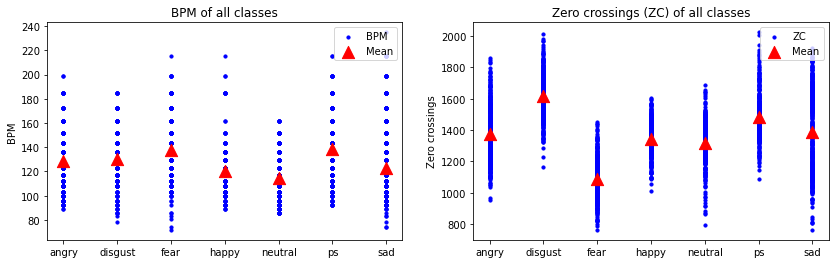

In [37]:
plt.rcParams['figure.figsize'] = [14, 4]
plt.subplot(121)
plt.scatter(emotion, bpm, s=10, color='blue')
plt.scatter(df_mean_bpm['emotion'], df_mean_bpm['bpm'], s=150, color='red', marker='^')
plt.ylabel('BPM')
plt.title('BPM of all classes')
plt.legend(['BPM', 'Mean'], loc="upper right")

plt.subplot(122)
plt.scatter(emotion, zero_crossings, s=10, color='blue')
plt.scatter(df_mean_zc['emotion'], df_mean_zc['zc'], s=150, color='red', marker='^')
plt.ylabel('Zero crossings')
plt.title('Zero crossings (ZC) of all classes')
plt.legend(['ZC', 'Mean'], loc="upper right")

#### Observação: A análise dos BPM indica que não é uma feature viável pois não só existe um desvio-padrão elevado entre as samples como a média encontra-se similar entre as classes. 

#### No zero-crossing observa-se uma maior separação dos dados por emoção. A título de exemplo a classe disgust e fear apresentam uma boa separação média. No entanto, o desvio-padrão continua a ser demasiado elevado nas diversas emoções o que torna o zero-crossing uma feature pouco viável. 

### Análise focada de 4 emoções: Angry, Disgust, Fear, Neutral ###

In [11]:
angry_idx, disgust_idx, neutral_idx, fear_idx = [], [], [], []

for i in range(len(df)):
    # angry
    if 'angry' in df['sound_emotion'][i] and 'OAF' in df['sound_speaker'][i]:
        if 'back' in df['sound_word'][i] or 'join' in df['sound_word'][i] \
        or 'knock' in df['sound_word'][i]:
            angry_idx.append(i)
    elif 'angry' in df['sound_emotion'][i] and 'YAF' in df['sound_speaker'][i]:
        if 'back' in df['sound_word'][i] or 'join' in df['sound_word'][i] \
        or 'knock' in df['sound_word'][i]:
            angry_idx.append(i)
            
    # disgust       
    elif 'disgust' in df['sound_emotion'][i] and 'OAF' in df['sound_speaker'][i]:
        if 'back' in df['sound_word'][i] or 'join' in df['sound_word'][i] \
        or 'knock' in df['sound_word'][i]:
            disgust_idx.append(i)
    elif 'disgust' in df['sound_emotion'][i] and 'YAF' in df['sound_speaker'][i]:
        if 'back' in df['sound_word'][i] or 'join' in df['sound_word'][i] \
        or 'knock' in df['sound_word'][i]:
            disgust_idx.append(i)
            
    # neutral
    elif 'neutral' in df['sound_emotion'][i] and 'OAF' in df['sound_speaker'][i]:
        if 'back' in df['sound_word'][i] or 'join' in df['sound_word'][i] \
        or 'knock' in df['sound_word'][i]:
            neutral_idx.append(i)
    elif 'neutral' in df['sound_emotion'][i] and 'YAF' in df['sound_speaker'][i]:
        if 'back' in df['sound_word'][i] or 'join' in df['sound_word'][i] \
        or 'knock' in df['sound_word'][i]:
            neutral_idx.append(i)
            
    # ps
    elif 'fear' in df['sound_emotion'][i] and 'OAF' in df['sound_speaker'][i]:
        if 'back' in df['sound_word'][i] or 'join' in df['sound_word'][i] \
        or 'knock' in df['sound_word'][i]:
            fear_idx.append(i)
    elif 'fear' in df['sound_emotion'][i] and 'YAF' in df['sound_speaker'][i]:
        if 'back' in df['sound_word'][i] or 'join' in df['sound_word'][i] \
        or 'knock' in df['sound_word'][i]:
            fear_idx.append(i)
            

emt_idx_4cl = angry_idx + disgust_idx + neutral_idx + fear_idx  

### MFCC das 4 emoções ###

100%|██████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 21.46it/s]


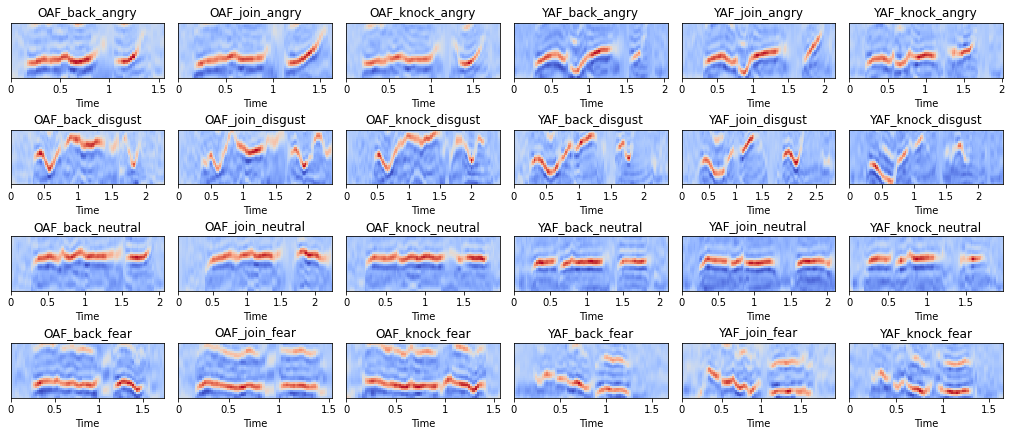

In [39]:
plt.rcParams['figure.figsize'] = [14, 6]

for i in tqdm(range(len(emt_idx_4cl))):
    mfccs = librosa.feature.mfcc(df['sound_filtered'][emt_idx_4cl[i]], sr, n_mfcc=40, fmax=sr//4)
    plt.subplot(4,6,i+1)
    mfccs_line = mfccs[12:40, :]  
    img = librosa.display.specshow(mfccs_line, x_axis='time')
    plt.title(df['sound_name'][emt_idx_4cl[i]].split('\\')[1].split('.')[0])
    
plt.tight_layout(pad=0.5)

#### Observação: Verificou-se que dos coeficientes 12 até ao 40 encontra-se a parte mais relevante da imagem.  

### STFT das 4 emoções ###

100%|██████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 54.70it/s]


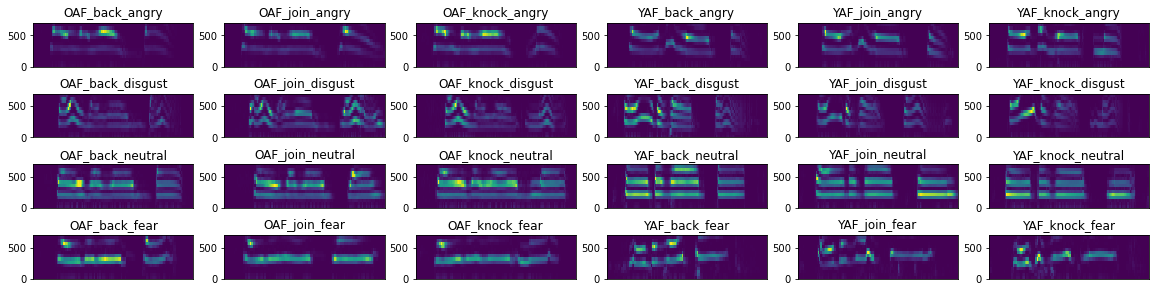

In [40]:
plt.rcParams['figure.figsize'] = [16, 4]

fig, axs = plt.subplots(4, 6)

m = [[0,0], [0,1], [0,2], [0,3], [0,4], [0,5], 
     [1,0], [1,1], [1,2], [1,3], [1,4], [1,5], 
     [2,0], [2,1], [2,2], [2,3], [2,4], [2,5], 
     [3,0], [3,1], [3,2], [3,3], [3,4], [3,5]
    ]

win = int(sr * 0.02)

for i in tqdm(range(len(emt_idx_4cl))):      
    f, t, S1 = signal.spectrogram(df['sound_filtered'][emt_idx_4cl[i]], sr, nperseg=win, noverlap=win//4, 
                                  window='hamming', scaling='spectrum', mode='magnitude')
 
    ax = axs[m[i][0], m[i][1]]
    # pegar somente a zona de interesse do espectograma
    c = ax.pcolor(t, f[:15], S1[:15][:])
    ax.set_title(df['sound_name'][emt_idx_4cl[i]].split('\\')[1].split('.')[0])
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    
fig.tight_layout(pad=0.5)

#### Observação: Verificou-se que o padrão relevante do espectograma encontra-se até aproximadamente os 750Hz. 

## Pré-processamento do áudio ##

### Duração dos Audios ###

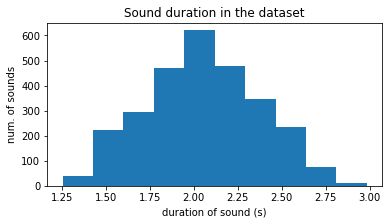

In [44]:
plt.rcParams['figure.figsize'] = [6, 3]
plt.hist(df['sound_raw_data'].str.len()/sr)
plt.title("Sound duration in the dataset")
plt.ylabel("num. of sounds")
plt.xlabel("duration of sound (s)")
print("")

##### Observação: A duração do som ao longo do dataset não é igual para todos os samples. 

### Operação PAD para igualar a duração dos samples do dataset ###

Max number of samples in the dataset:  65815
Min number of samples in the dataset:  27653 




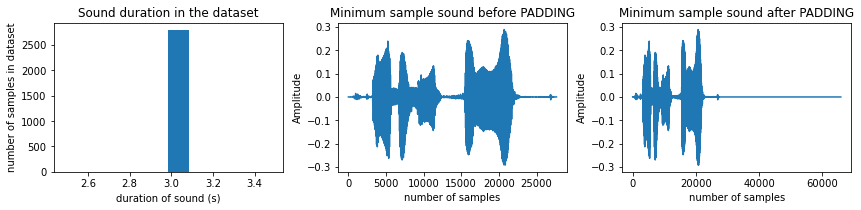

In [12]:
# pad operation - coloca zeros em todos os samples inferiores ao máximo para não se perder informação #

max_sample = np.max(df['sound_filtered'].str.len())
# obter o sample com o numero minimo de samples i.e. obter o som que tem menos duração
min_sample_idx = np.argmin(df['sound_filtered'].str.len())

print("Max number of samples in the dataset: ", max_sample)
print("Min number of samples in the dataset: ", np.min(df['sound_filtered'].str.len()), "\n")

dataset = []
for i in range(len(df)):
    if(len(df['sound_filtered']) < max_sample):
        N = max_sample - len(df['sound_filtered'][i])
        dataset.append(np.pad(df['sound_filtered'][i], (0, N), 'constant'))
    else:
        dataset.append(df['sound_filtered'][i])
        
plt.rcParams['figure.figsize'] = [12, 3]
plt.subplot(131)
res = [len(row)/sr for row in dataset]
plt.hist(res)
plt.title("Sound duration in the dataset")
plt.ylabel("number of samples in dataset")
plt.xlabel("duration of sound (s)")
plt.subplot(132) 
plt.plot(df['sound_filtered'][min_sample_idx])
plt.title("Minimum sample sound before PADDING")
plt.ylabel("Amplitude")
plt.xlabel("number of samples")
plt.subplot(133)
plt.plot(dataset[min_sample_idx])
plt.title("Minimum sample sound after PADDING")
plt.ylabel("Amplitude")
plt.xlabel("number of samples")
plt.tight_layout(pad=1.0)
print("")

### Extrair coeficientes 12-40 dos MFCC como features ###

In [13]:
data_mfcc = []
data_y = []
for i in tqdm(range(len(dataset))):
    if(df['sound_emotion'][i] == 'angry' or df['sound_emotion'][i] == 'disgust' or df['sound_emotion'][i] == 'fear' 
       or df['sound_emotion'][i] == 'neutral'):
        mfccs = librosa.feature.mfcc(dataset[i], sr, n_mfcc=40, fmax=sr//4)
        mfccs_line = mfccs[12:40, :] 
        flatten = mfccs_line.flatten('C')
        data_mfcc.append(flatten)
        data_y.append(df['sound_emotion'][i])

100%|███████████████████████████████████████████████████| 2800/2800 [00:18<00:00, 155.17it/s]


### Extrair 15 linhas (dos 0-750Hz) do espectograma (STFT) como features ###

In [15]:
win = int(sr * 0.02)
data_stft = []
for i in tqdm(range(len(dataset))):    
    if(df['sound_emotion'][i] == 'angry' or df['sound_emotion'][i] == 'disgust' or df['sound_emotion'][i] == 'fear' 
       or df['sound_emotion'][i] == 'neutral'):

        f, t, S1 = signal.spectrogram(dataset[i], sr, nperseg=win, noverlap=win//4, 
                                      window='hamming', scaling='spectrum', mode='magnitude')
        
        flatten = S1[0:15].flatten('C')
        data_stft.append(flatten)

100%|███████████████████████████████████████████████████| 2800/2800 [00:02<00:00, 952.70it/s]


### Análise dos features através dos algoritmos PCA/LDA ###

#### Extração dos labels ####

In [14]:
lb = LabelEncoder()
y1 = to_categorical(lb.fit_transform(data_y))
y2 = np.argmax(y1, axis=1)
num_classes = len(lb.classes_)
print("classes: ", lb.classes_)

classes:  ['angry' 'disgust' 'fear' 'neutral']


#### Converter dados para numpy array ####

In [16]:
X_mfcc = np.array(data_mfcc)
X_stft = np.array(data_stft)
X_mfcc.shape, X_stft.shape, y1.shape

((1600, 3612), (1600, 2970), (1600, 4))

#### Algortimos PCA/LDA ####

In [17]:
lda_mfcc = LinearDiscriminantAnalysis(n_components=3)
X_mfcc_lda = lda_mfcc.fit(X_mfcc, y2).transform(X_mfcc)

lda_stft = LinearDiscriminantAnalysis(n_components=3)
X_stft_lda = lda_stft.fit(X_stft, y2).transform(X_stft)

X_mfcc_lda.shape, X_stft_lda.shape

((1600, 3), (1600, 3))

In [18]:
pca_mfcc = PCA(n_components=len(data_mfcc)//16)
X_mfcc_pca = pca_mfcc.fit(X_mfcc).transform(X_mfcc) 

pca_stft = PCA(n_components=len(data_stft)//16)
X_stft_pca = pca_stft.fit(X_stft).transform(X_stft) 

X_mfcc_pca.shape, X_stft_pca.shape

((1600, 100), (1600, 100))

#### Comparação do MFCC & STFT através do plot do PCA/LDA com os 2 primeiros "principal components" ####

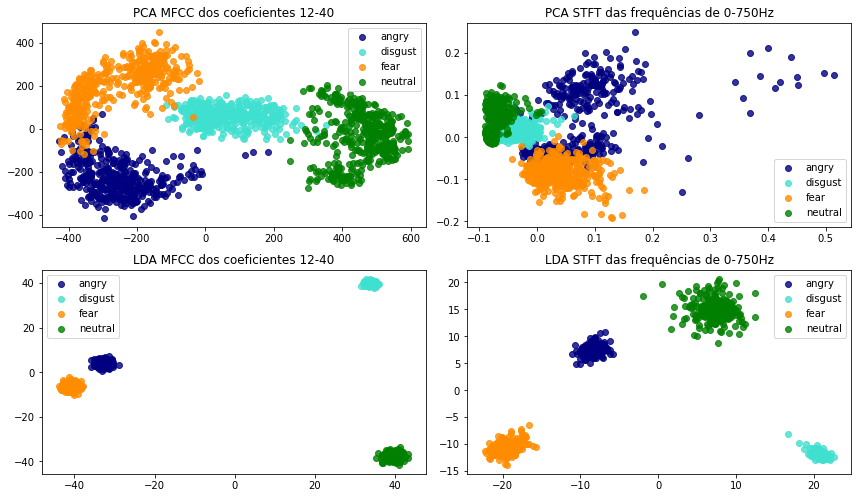

In [19]:
plt.rcParams['figure.figsize'] = [12, 7]

targets = ['angry', 'disgust', 'fear', 'neutral']
colors = ['navy', 'turquoise', 'darkorange', 'green']

plt.subplot(221)
for color, i, targets in zip(colors, [0, 1, 2, 3], targets):
    plt.scatter(X_mfcc_pca[y2 == i, 0], X_mfcc_pca[y2 == i, 1], alpha=.8, color=color, label=targets)
plt.legend(loc='upper right', shadow=False, scatterpoints=1)
plt.title('PCA MFCC dos coeficientes 12-40')

targets = ['angry', 'disgust', 'fear', 'neutral']
colors = ['navy', 'turquoise', 'darkorange', 'green']
plt.subplot(222)
for color, i, targets in zip(colors, [0, 1, 2, 3], targets):
    plt.scatter(X_stft_pca[y2 == i, 0], X_stft_pca[y2 == i, 1], alpha=.8, color=color, label=targets)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA STFT das frequências de 0-750Hz')

targets = ['angry', 'disgust', 'fear', 'neutral']
colors = ['navy', 'turquoise', 'darkorange', 'green']
plt.subplot(223)
for color, i, targets in zip(colors, [0, 1, 2, 3], targets):
    plt.scatter(X_mfcc_lda[y2 == i, 0], X_mfcc_lda[y2 == i, 1], alpha=.8, color=color, label=targets)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA MFCC dos coeficientes 12-40')

targets = ['angry', 'disgust', 'fear', 'neutral']
colors = ['navy', 'turquoise', 'darkorange', 'green']
plt.subplot(224)
for color, i, targets in zip(colors, [0, 1, 2, 3], targets):
    plt.scatter(X_stft_lda[y2 == i, 0], X_stft_lda[y2 == i, 1], alpha=.8, color=color, label=targets)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA STFT das frequências de 0-750Hz')

plt.tight_layout(pad=1.0)

#### Observação: Apesar de o STFT e o MFCC terem separado bem as classes usando o LDA há uma clara diferença usando o algortimo PCA visto que o MFCC separa melhor as classes o que indica que é um feature mais adequado.

### Verificar outros potenciais features (Chroma e Espectograma de Mel) ###

 29%|██████████████████▍                                            | 7/24 [00:00<00:00, 20.78it/s]

ERROR! Session/line number was not unique in database. History logging moved to new session 438


100%|██████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 25.70it/s]


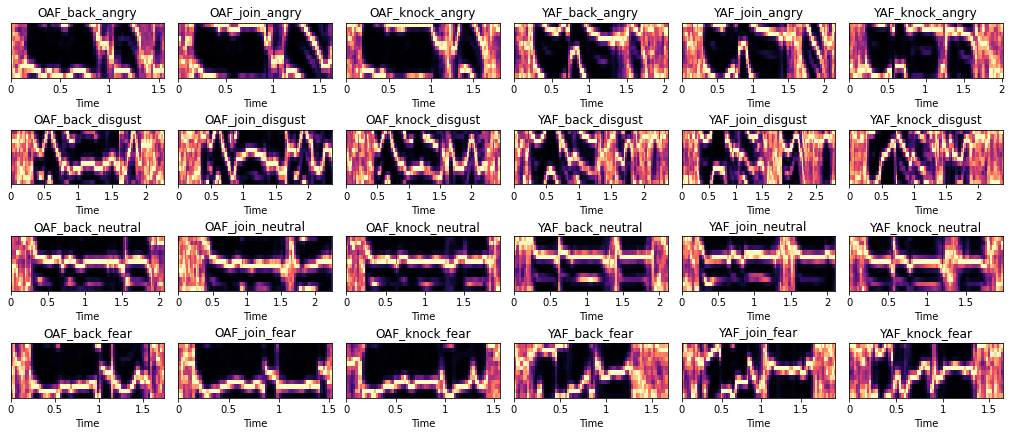

In [55]:
plt.rcParams['figure.figsize'] = [14, 6]

for i in tqdm(range(len(emt_idx_4cl))):
    plt.subplot(4,6,i+1)
    stft = np.abs(librosa.stft(df['sound_filtered'][emt_idx_4cl[i]]))
    chroma  = librosa.feature.chroma_stft(S=stft, sr=sr) 

    librosa.display.specshow(chroma, x_axis='time')
    plt.title(df['sound_name'][emt_idx_4cl[i]].split('\\')[1].split('.')[0])
    
plt.tight_layout(pad=0.5)

#### Observação: A análise do chroma não mostra ser uma feature relevante visto que o padrão não é constante entre palavras/users.

100%|██████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 28.27it/s]


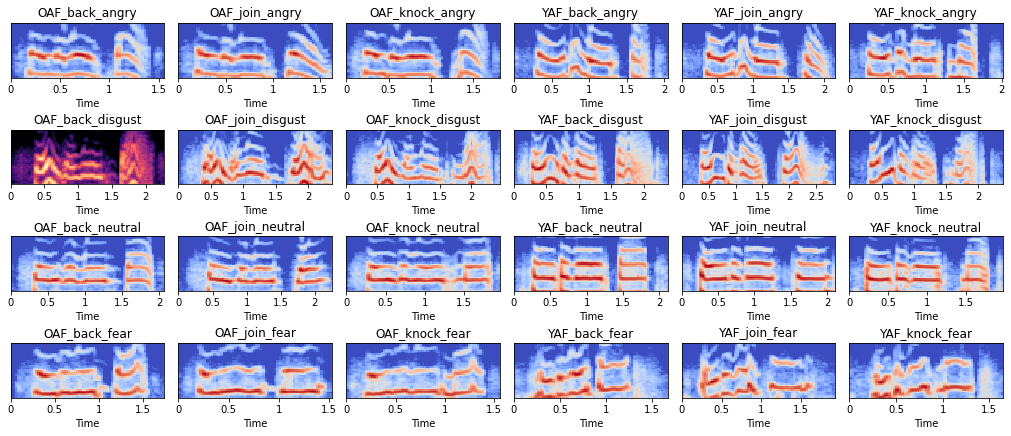

In [59]:
plt.rcParams['figure.figsize'] = [14, 6]

for i in tqdm(range(len(emt_idx_4cl))):
    plt.subplot(4,6,i+1)
    spectrogram = librosa.feature.melspectrogram(y=df['sound_filtered'][emt_idx_4cl[i]], sr=sr, n_mels=128,fmax=sr//4) 
    spectrogram = librosa.power_to_db(spectrogram)
    spec = spectrogram[10:48,:]
    librosa.display.specshow(spec, x_axis='time')
    plt.title(df['sound_name'][emt_idx_4cl[i]].split('\\')[1].split('.')[0])
    
plt.tight_layout(pad=0.5)

#### Observação: O espectograma de mel demosntra um padrão similar ao MFCC o que poderá ser um potencial feature relevante.

### MFCC vs Espectograma de Mel usando a análise PCA/LDA ###

In [60]:
data_mel_spec = []
for i in tqdm(range(len(dataset))):
    if(df['sound_emotion'][i] == 'angry' or df['sound_emotion'][i] == 'disgust' or df['sound_emotion'][i] == 'fear' 
       or df['sound_emotion'][i] == 'neutral'):
        mel_spectrogram = librosa.feature.melspectrogram(y=dataset[i], sr=sr, n_mels=128,fmax=sr//4) 
        mel_spectrogram = librosa.power_to_db(mel_spectrogram)
        mel_spectrogram_line = mel_spectrogram[10:48,:]
        flatten = mel_spectrogram_line.flatten('C')
        data_mel_spec.append(flatten)

100%|█████████████████████████████████████████████████████████| 2800/2800 [00:18<00:00, 150.67it/s]


In [61]:
X_mel_spec = np.array(data_mel_spec)
X_mel_spec.shape

(1600, 4902)

In [62]:
lda_mel_spec = LinearDiscriminantAnalysis(n_components=3)
X_mel_spec_lda = lda_mel_spec.fit(X_mel_spec, y2).transform(X_mel_spec)

pca_mel_spec = PCA(n_components=len(X_mel_spec)//16)
X_mel_spec_pca = pca_mel_spec.fit(X_mel_spec).transform(X_mel_spec) 

X_mel_spec_lda.shape, X_mel_spec_pca.shape

((1600, 3), (1600, 100))

#### Comparação do MFCC & Espectograma de Mel através do plot do PCA/LDA com os 2 primeiros "principal components" ####

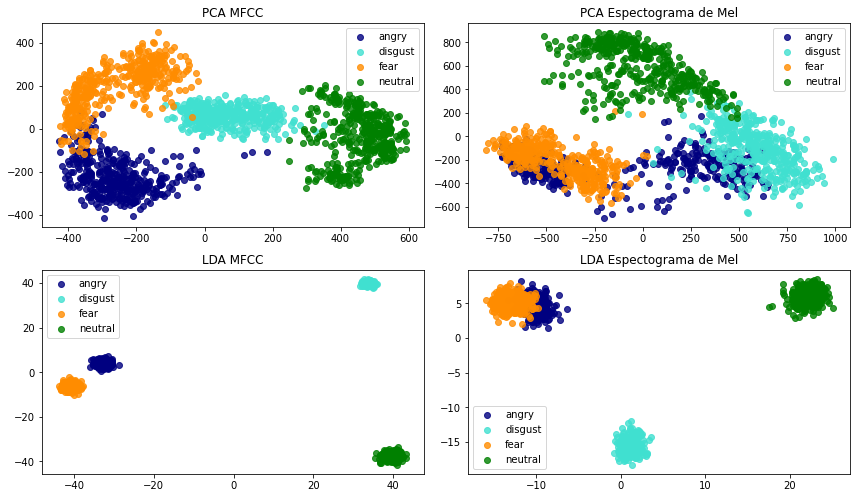

In [63]:
plt.rcParams['figure.figsize'] = [12, 7]

targets = ['angry', 'disgust', 'fear', 'neutral']
colors = ['navy', 'turquoise', 'darkorange', 'green']

plt.subplot(221)
for color, i, targets in zip(colors, [0, 1, 2, 3], targets):
    plt.scatter(X_mfcc_pca[y2 == i, 0], X_mfcc_pca[y2 == i, 1], alpha=.8, color=color, label=targets)
plt.legend(loc='upper right', shadow=False, scatterpoints=1)
plt.title('PCA MFCC')

targets = ['angry', 'disgust', 'fear', 'neutral']
colors = ['navy', 'turquoise', 'darkorange', 'green']
plt.subplot(222)
for color, i, targets in zip(colors, [0, 1, 2, 3], targets):
    plt.scatter(X_mel_spec_pca[y2 == i, 0], X_mel_spec_pca[y2 == i, 1], alpha=.8, color=color, label=targets)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA Espectograma de Mel')

targets = ['angry', 'disgust', 'fear', 'neutral']
colors = ['navy', 'turquoise', 'darkorange', 'green']
plt.subplot(223)
for color, i, targets in zip(colors, [0, 1, 2, 3], targets):
    plt.scatter(X_mfcc_lda[y2 == i, 0], X_mfcc_lda[y2 == i, 1], alpha=.8, color=color, label=targets)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA MFCC')

targets = ['angry', 'disgust', 'fear', 'neutral']
colors = ['navy', 'turquoise', 'darkorange', 'green']
plt.subplot(224)
for color, i, targets in zip(colors, [0, 1, 2, 3], targets):
    plt.scatter(X_mel_spec_lda[y2 == i, 0], X_mel_spec_lda[y2 == i, 1], alpha=.8, color=color, label=targets)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA Espectograma de Mel')

plt.tight_layout(pad=1.0)

#### Observação: O MFCC é mais adequado para a análise de emoções deste dataset que o Espectograma de Mel visto que separa melhor as classes tanto no caso do PCA como no LDA

### Treinar os coeficientes 12-40 do MFCC com SVM para obter feature importance ###

#### Normalização dos dados ####

In [65]:
print("Feature shape: ", X_mfcc.shape)
print("\nFeature Max: ", X_mfcc.max().round(1), "\nFeature Min: ", X_mfcc.min().round(1))
print("Feature Mean: ", X_mfcc.mean().round(1), "\nFeature std: ", X_mfcc.std().round(1))

Feature shape:  (1600, 3612)

Feature Max:  76.9 
Feature Min:  -60.6
Feature Mean:  -2.3 
Feature std:  11.4


In [69]:
# valores máximos de média e desvio-padrão considerados
Xmean = -2.5
Xstd = 11.5
X_mfcc_norm = (X_mfcc - Xmean) / Xstd
X_mfcc_norm.mean(), X_mfcc_norm.std()

(0.018006368041792772, 0.9873335200989477)

#### Separar em dados de treino e dados de teste ####

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_mfcc_norm, y2, test_size=0.2, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape)

(1280, 3612) (320, 3612) (1280,)


#### Treinar o modelo ####

In [71]:
svc_linear = SVC(kernel='linear', random_state=0)
svc_linear.fit(X_train, y_train)
svc_linear.score(X_test, y_test).round(4)

1.0

#### Verificar o tamanho dos dados ####

In [34]:
mfccs1 = librosa.feature.mfcc(dataset[0], sr, n_mfcc=40, fmax=sr//4)
mfccs_line1 = mfccs1[12:40, :]
m_shape = mfccs_line1.shape
m_shape, 28*129

((28, 129), 3612)

### Obter a importância de cada coeficiente escolhido do MFCC ###

In [128]:
contributions = abs(svc_linear.coef_).mean(axis=0)

m = list(range(0, 3612+129, 129))
s = []
for i in range(len(m)-1):
    #print(str(m[i]) + ", " + str(m[i+1]))
    s.append(contributions[m[i]:m[i+1]].mean())
    
feature_number = 11 + (np.arange(len(s)) + 1)

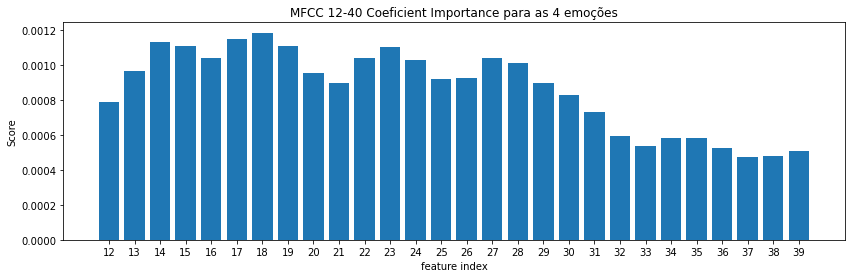

In [129]:
plt.rcParams['figure.figsize'] = [14, 4]
plt.bar(feature_number, s, align='center')
plt.xlabel('feature index')
plt.ylabel('Score')
plt.title('MFCC 12-40 Coeficient Importance para as 4 emoções')
plt.xticks(np.arange(12, 40, step=1))
print("")

#### Observação: Os coeficientes que são mais relevantes são os 13-19, 22-24 e 27-28 pois são os picos mais relevantes.

### PCA/LDA usando somente os coeficientes 13-19, 22-24 e 27-28 do MFCC ###

In [20]:
data_mfcc_smaller = []

for i in tqdm(range(len(dataset))):
    if(df['sound_emotion'][i] == 'angry' or df['sound_emotion'][i] == 'disgust' or df['sound_emotion'][i] == 'fear' 
       or df['sound_emotion'][i] == 'neutral'):
        mfccs = librosa.feature.mfcc(dataset[i], sr, n_mfcc=40, fmax=sr//4)
        mfccs_line1 = mfccs[13:20, :] 
        mfccs_line2 = mfccs[22:25, :] 
        mfccs_line3 = mfccs[27:29, :]
        mfccs_linef = np.vstack((mfccs_line1, mfccs_line2, mfccs_line3))
        flatten = mfccs_linef.flatten('C')
        data_mfcc_smaller.append(flatten)

X_mfcc_smaller = np.array(data_mfcc_smaller)

100%|███████████████████████████████████████████████████| 2800/2800 [00:18<00:00, 154.76it/s]


In [21]:
lda_mfcc_smaller = LinearDiscriminantAnalysis(n_components=3)
X_mfcc_lda_smaller = lda_mfcc_smaller.fit(X_mfcc_smaller, y2).transform(X_mfcc_smaller)

pca_mfcc_smaller = PCA(n_components=len(data_mfcc_smaller)//16)
X_mfcc_pca_smaller = pca_mfcc_smaller.fit(X_mfcc_smaller).transform(X_mfcc_smaller) 

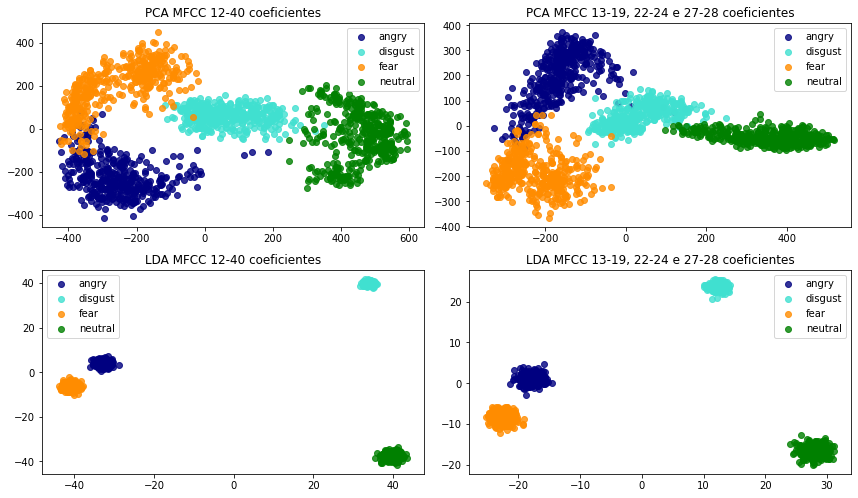

In [41]:
plt.rcParams['figure.figsize'] = [12, 7]

targets = ['angry', 'disgust', 'fear', 'neutral']
colors = ['navy', 'turquoise', 'darkorange', 'green']

plt.subplot(221)
for color, i, targets in zip(colors, [0, 1, 2, 3], targets):
    plt.scatter(X_mfcc_pca[y2 == i, 0], X_mfcc_pca[y2 == i, 1], alpha=.8, color=color, label=targets)
plt.legend(loc='upper right', shadow=False, scatterpoints=1)
plt.title('PCA MFCC 12-40 coeficientes')

targets = ['angry', 'disgust', 'fear', 'neutral']
colors = ['navy', 'turquoise', 'darkorange', 'green']
plt.subplot(222)
for color, i, targets in zip(colors, [0, 1, 2, 3], targets):
    plt.scatter(X_mfcc_pca_smaller[y2 == i, 0], X_mfcc_pca_smaller[y2 == i, 1], alpha=.8, color=color, label=targets)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA MFCC 13-19, 22-24 e 27-28 coeficientes')

targets = ['angry', 'disgust', 'fear', 'neutral']
colors = ['navy', 'turquoise', 'darkorange', 'green']
plt.subplot(223)
for color, i, targets in zip(colors, [0, 1, 2, 3], targets):
    plt.scatter(X_mfcc_lda[y2 == i, 0], X_mfcc_lda[y2 == i, 1], alpha=.8, color=color, label=targets)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA MFCC 12-40 coeficientes')

targets = ['angry', 'disgust', 'fear', 'neutral']
colors = ['navy', 'turquoise', 'darkorange', 'green']
plt.subplot(224)
for color, i, targets in zip(colors, [0, 1, 2, 3], targets):
    plt.scatter(X_mfcc_lda_smaller[y2 == i, 0], X_mfcc_lda_smaller[y2 == i, 1], alpha=.8, color=color, label=targets)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA MFCC 13-19, 22-24 e 27-28 coeficientes')

plt.tight_layout(pad=1.0)

### Comparação usando as 3 componentes principais do PCA/LDA (3D) ###

In [1]:
%matplotlib notebook

targets = ['angry', 'disgust', 'fear', 'neutral']
colors = ['navy', 'turquoise', 'darkorange', 'green']

fig = plt.figure(figsize=(9.9,4))
ax = fig.add_subplot(121, projection='3d')

for color, i, targets in zip(colors, [0, 1, 2, 3], targets):
    ax.scatter(X_mfcc_pca[y2 == i, 0], X_mfcc_pca[y2 == i, 1], X_mfcc_pca[y2 == i, 2], 
                alpha=.8, color=color, label=targets)
ax.legend(loc='upper right', shadow=False, scatterpoints=1)
ax.view_init(30, 310)
plt.title('PCA MFCC 12-40 coeficientes')


targets = ['angry', 'disgust', 'fear', 'neutral']
colors = ['navy', 'turquoise', 'darkorange', 'green']
ax = fig.add_subplot(122, projection='3d')

for color, i, targets in zip(colors, [0, 1, 2, 3], targets):
    ax.scatter(X_mfcc_pca_smaller[y2 == i, 0], X_mfcc_pca_smaller[y2 == i, 1], 
               X_mfcc_pca_smaller[y2 == i, 2], alpha=.8, color=color, label=targets)
ax.legend(loc='upper right', shadow=False, scatterpoints=1)
ax.view_init(30, 310)
plt.title('PCA MFCC 12-32 coeficientes')

NameError: name 'plt' is not defined

#### Colocar o plot no modo inline

In [48]:
%matplotlib inline

#### Observação: Com a redução dos coeficientes de 28 (40-12=28) para 12 (7+3+2=12) verifica-se que a nova abordagem consegue separar bem as classes sem perdas de precisão.
#### Conclusão: Considera-se que os coeficientes 13-19, 22-24 e 27-28 são os mais adequados para classificar e separar as emoções.

### Treinar features selecionados com uma rede neuronal complexa ###

#### Extrair o dataset ####

In [49]:
mfccs_data = []
for i in tqdm(range(len(dataset))):
    if(df['sound_emotion'][i] == 'angry' or df['sound_emotion'][i] == 'disgust' or df['sound_emotion'][i] == 'fear' 
       or df['sound_emotion'][i] == 'neutral'):
        mfccs = librosa.feature.mfcc(dataset[i], sr, n_mfcc=40, fmax=sr//4)
        mfccs_line1 = mfccs[13:20, :] 
        mfccs_line2 = mfccs[22:25, :] 
        mfccs_line3 = mfccs[27:29, :]
        mfccs_linef = np.vstack((mfccs_line1, mfccs_line2, mfccs_line3)) 
        mfccs_data.append(mfccs_linef)

100%|███████████████████████████████████████████████████| 2800/2800 [00:19<00:00, 140.24it/s]


#### Normalização do dataset ####

In [244]:
X = np.array(mfccs_data)
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2], 1))
print("Image shape: ", X.shape)
print("\nImage Max: ", X.max().round(1), "\nImage Min: ", X.min().round(1))
print("Image Mean: ", X.mean().round(1), "\nImage std: ", X.std().round(1))

Image shape:  (1600, 12, 129, 1)

Image Max:  76.9 
Image Min:  -60.6
Image Mean:  -3.5 
Image std:  12.9


In [245]:
# valores máximos de média e desvio-padrão considerados
Xmean = -4
Xstd = 13
X = (X - Xmean) / Xstd
X.mean(), X.std()

(0.037825096487424326, 0.9956272563340781)

#### Codificar os labels ####

In [246]:
lb = LabelEncoder()
y_cat = to_categorical(lb.fit_transform(data_y))
num_classes = len(lb.classes_)
print("classes: ", lb.classes_)

classes:  ['angry' 'disgust' 'fear' 'neutral']


#### Repartir dados por treino, validação e teste ####

In [247]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print(X_train.shape, X_val.shape, X_test.shape)

(960, 12, 129, 1) (320, 12, 129, 1) (320, 12, 129, 1)


#### Rede neuronal CNN ####

In [248]:
model = Sequential([
    Input(shape=(X.shape[1], X.shape[2], 1)),
    Conv2D(32, 3, activation='relu', padding="same"),
    MaxPooling2D(2, 2, padding='same'),
    Dropout(0.1),
    Conv2D(64, 3, activation='relu', padding="same"),
    MaxPooling2D(2, 2, padding='same'),
    Dropout(0.1),
    Conv2D(64, 3, activation='relu', padding="same"),
    MaxPooling2D(2, 2, padding='same'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(24, activation='relu'),
    Dense(num_classes, activation='softmax'),
])

es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

m_loss = CategoricalCrossentropy(label_smoothing=0.1)
model.compile(optimizer="adam", loss=m_loss, metrics=["accuracy"])

#### Treinar CNN ####

In [249]:
history = model.fit(X_train, y_train, epochs=8, validation_data=(X_val, y_val), callbacks=[es])

Train on 960 samples, validate on 320 samples
Epoch 1/8
960/960 [==============================] - 2s 2ms/sample - loss: 0.7750 - accuracy: 0.7969 - val_loss: 0.4180 - val_accuracy: 0.9969
Epoch 2/8
960/960 [==============================] - 1s 780us/sample - loss: 0.4231 - accuracy: 0.9937 - val_loss: 0.3816 - val_accuracy: 0.9969
Epoch 3/8
960/960 [==============================] - 1s 787us/sample - loss: 0.3991 - accuracy: 0.9979 - val_loss: 0.3687 - val_accuracy: 1.0000
Epoch 4/8
960/960 [==============================] - 1s 819us/sample - loss: 0.3874 - accuracy: 1.0000 - val_loss: 0.3649 - val_accuracy: 1.0000
Epoch 5/8
960/960 [==============================] - 1s 763us/sample - loss: 0.3814 - accuracy: 0.9990 - val_loss: 0.3715 - val_accuracy: 1.0000
Epoch 6/8
960/960 [==============================] - 1s 787us/sample - loss: 0.3772 - accuracy: 1.0000 - val_loss: 0.3637 - val_accuracy: 1.0000
Epoch 7/8
960/960 [==============================] - 1s 780us/sample - loss: 0.3734 - 

#### Precisão dos dados de teste ####

In [250]:
y_pred = model.predict(X_test)
print("Accuracy of test dataset: ", np.round(accuracy_score(np.argmax(y_pred, axis=1), np.argmax(y_test, axis=1)), 4))

Accuracy of test dataset:  0.9938


#### Learning Curves ####

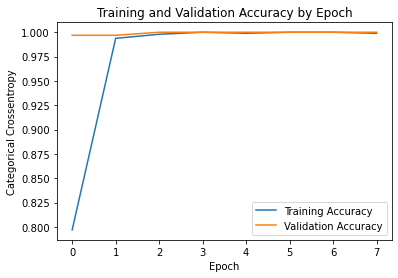

In [251]:
plt.rcParams['figure.figsize'] = [6, 4]
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')

plt.title('Training and Validation Accuracy by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Categorical Crossentropy')
plt.legend()
plt.show()

#### Confusion Matrix & Classification Report ####


Classification Report:
              precision    recall  f1-score   support

       angry       0.98      1.00      0.99        84
     disgust       1.00      1.00      1.00        73
        fear       1.00      0.97      0.99        75
     neutral       1.00      1.00      1.00        88

    accuracy                           0.99       320
   macro avg       0.99      0.99      0.99       320
weighted avg       0.99      0.99      0.99       320

Confusion Matrix:


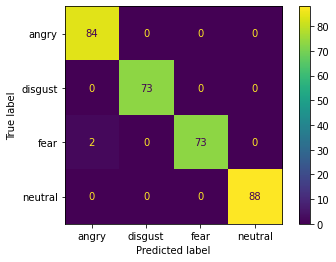

In [258]:
print('Classification Report:')
print(classification_report(np.argmax(y_pred, axis=1), np.argmax(y_test, axis=1), target_names=lb.classes_))

print('\nConfusion Matrix:')
cm = confusion_matrix(np.argmax(y_pred, axis=1), np.argmax(y_test, axis=1))
#print(cm)
cmd = ConfusionMatrixDisplay(cm, display_labels=lb.classes_)
cmd.plot()

## Análise de todas as emoções ##

100%|██████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.22it/s]


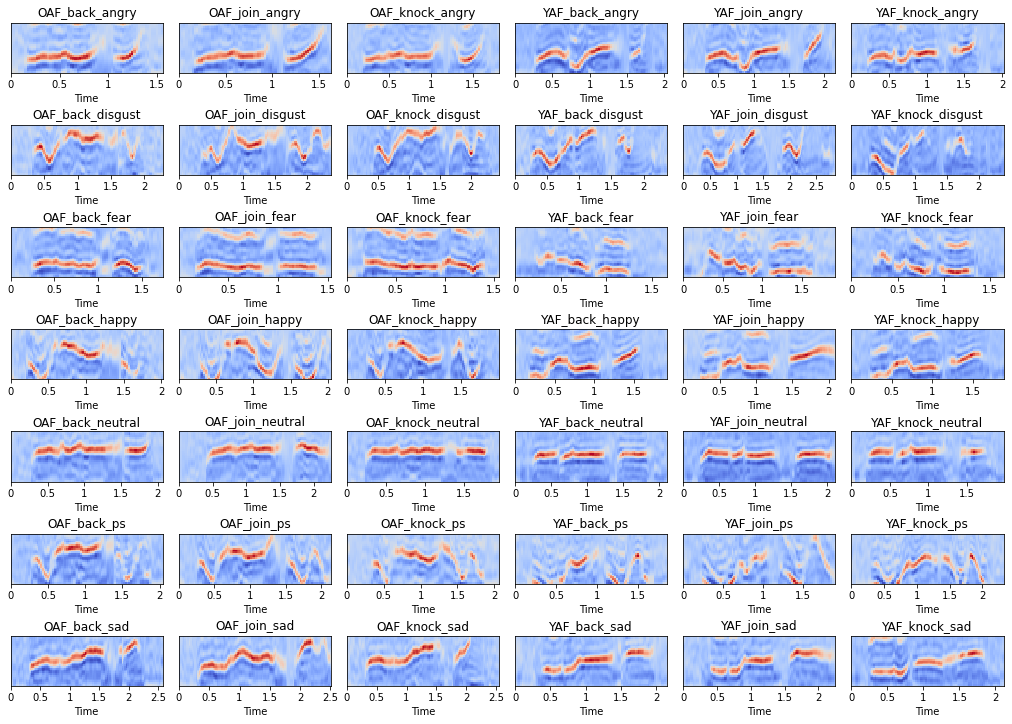

In [191]:
plt.rcParams['figure.figsize'] = [14, 10]

for i in tqdm(range(len(emt_idx_all))):
    mfccs = librosa.feature.mfcc(df['sound_filtered'][emt_idx_all[i]], sr, n_mfcc=40, fmax=sr//4)
    plt.subplot(7,6,i+1)
    mfccs_line = mfccs[12:40, :]
    img = librosa.display.specshow(mfccs_line, x_axis='time')
    plt.title(df['sound_name'][emt_idx_all[i]].split('\\')[1].split('.')[0])
    plt.tight_layout(pad=0.5)

#### Observação: Tal como foi dito anteriormente o padrão principal encontra-se entre os 12-40 coeficientes

#### Extrair os coeficientes 12-40 de todas emoções ####

In [50]:
data_mfcc_all = []
data_y_all = []
for i in tqdm(range(len(dataset))):
        mfccs = librosa.feature.mfcc(dataset[i], sr, n_mfcc=40, fmax=sr//4)
        mfccs_line = mfccs[12:40, :] 
        flatten = mfccs_line.flatten('C')
        data_mfcc_all.append(flatten)
        data_y_all.append(df['sound_emotion'][i])

100%|████████████████████████████████████████████████████| 2800/2800 [00:36<00:00, 77.38it/s]


#### Codificação dos labels ####

In [51]:
lb = LabelEncoder()
y_all_1 = to_categorical(lb.fit_transform(data_y_all))
y_all_2 = np.argmax(y_all_1, axis=1)
num_classes = len(lb.classes_)
print("classes: ", lb.classes_)

classes:  ['angry' 'disgust' 'fear' 'happy' 'neutral' 'ps' 'sad']


#### Converter dados para array numpy ####

In [52]:
X_mfcc_all = np.array(data_mfcc_all)
X_mfcc_all.shape, y_all_2.shape

((2800, 3612), (2800,))

ERROR! Session/line number was not unique in database. History logging moved to new session 475


In [53]:
lda_mfcc_all = LinearDiscriminantAnalysis(n_components=6)
X_mfcc_all_lda = lda_mfcc_all.fit(X_mfcc_all, y_all_2).transform(X_mfcc_all)

pca_mfcc_all = PCA(n_components=len(data_mfcc_all)//16)
X_mfcc_all_pca = pca_mfcc_all.fit(X_mfcc_all).transform(X_mfcc_all) 

X_mfcc_all_lda.shape, X_mfcc_all_pca.shape

((2800, 6), (2800, 175))

#### Plots do PCA/LDA das features do MFCC para todas as emoções ####

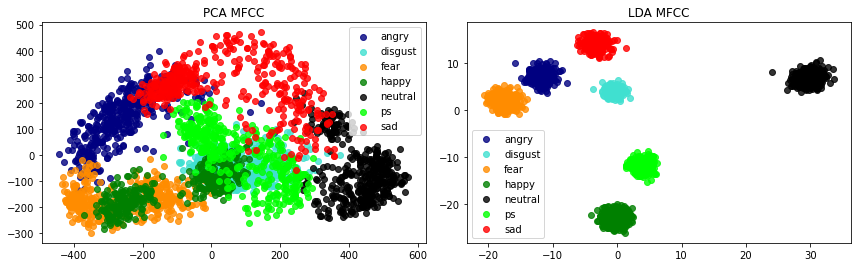

In [196]:
plt.rcParams['figure.figsize'] = [12, 7]

targets = lb.classes_
colors = ['navy', 'turquoise', 'darkorange', 'green', 'black', 'lime', 'red']

plt.subplot(221)
for color, i, targets in zip(colors, [0, 1, 2, 3, 4, 5, 6], targets):
    plt.scatter(X_mfcc_all_pca[y_all_2 == i, 0], X_mfcc_all_pca[y_all_2 == i, 1], alpha=.8, color=color, label=targets)
plt.legend(loc='upper right', shadow=False, scatterpoints=1)
plt.title('PCA MFCC')

targets = lb.classes_
colors = ['navy', 'turquoise', 'darkorange', 'green', 'black', 'lime', 'red']
plt.subplot(222)
for color, i, targets in zip(colors, [0, 1, 2, 3, 4, 5, 6], targets):
    plt.scatter(X_mfcc_all_lda[y_all_2 == i, 0], X_mfcc_all_lda[y_all_2 == i, 1], alpha=.8, color=color, label=targets)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA MFCC')

plt.tight_layout(pad=1.0)

#### Observação: Apesar do LDA conseguir separar bem as classes o PCA não consegue o fazer para 4 das emoções respectivamente: fear, happy, disgust e positive surprise.

### Treinar os coeficientes com SVM para obter feature importance de todas emoções ###

In [197]:
print("Feature shape: ", X_mfcc_all.shape)
print("\nFeature Max: ", X_mfcc_all.max().round(1), "\nFeature Min: ", X_mfcc_all.min().round(1))
print("Feature Mean: ", X_mfcc_all.mean().round(1), "\nFeature std: ", X_mfcc_all.std().round(1))

# valores máximos de média e desvio-padrão considerados
Xmean_all = -3
Xstd_all = 11
X_mfcc_all_norm = (X_mfcc_all - Xmean_all) / Xstd_all
X_mfcc_all_norm.mean(), X_mfcc_all_norm.std()

Feature shape:  (2800, 3612)

Feature Max:  76.9 
Feature Min:  -60.6
Feature Mean:  -2.4 
Feature std:  11.1


(0.05657011569005697, 1.0106080368788757)

#### Separação dos dados de treino e validação ####

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X_mfcc_all_norm, y_all_2, test_size=0.2, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape)

(2240, 3612) (560, 3612) (2240,)


#### Treinar SVM ####

In [199]:
svc_linear_all = SVC(kernel='linear', random_state=0)
svc_linear_all.fit(X_train, y_train)
svc_linear_all.score(X_test, y_test).round(4)

0.9982

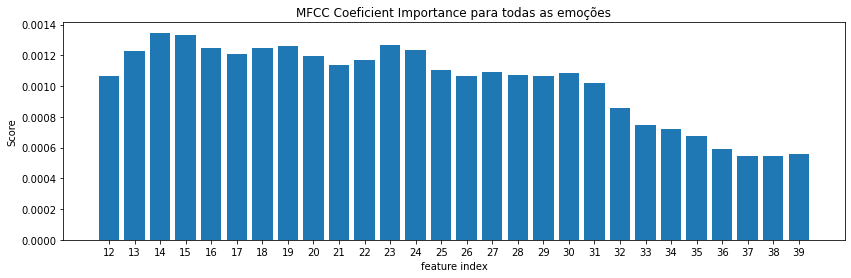

In [200]:
contributions = abs(svc_linear_all.coef_).mean(axis=0)

m = list(range(0, len(svc_linear_all.coef_[0])+129, 129))
s = []
for i in range(len(m)-1):
    s.append(contributions[m[i]:m[i+1]].mean())
    
feature_number = 11 + (np.arange(len(s)) + 1)

plt.rcParams['figure.figsize'] = [14, 4]
plt.bar(feature_number, s, align='center')
plt.xlabel('feature index')
plt.ylabel('Score')
plt.title('MFCC Coeficient Importance para todas as emoções')
plt.xticks(np.arange(12, 40, step=1))
print("")

#### Observação: Os coeficientes 12-32 são os features mais relevantes para a separação de emoções.

### Extrair as features selecionadas ###

In [54]:
data_mfcc_all_smaller = []

for i in tqdm(range(len(dataset))):
        mfccs = librosa.feature.mfcc(dataset[i], sr, n_mfcc=40, fmax=sr//4)
        mfccs_line1 = mfccs[12:33, :] 
        flatten = mfccs_line1.flatten('C')
        data_mfcc_all_smaller.append(flatten)

X_mfcc_all_smaller = np.array(data_mfcc_all_smaller)

100%|████████████████████████████████████████████████████| 2800/2800 [00:37<00:00, 73.95it/s]


### PCA/LDA com as features selecionadas ###

In [55]:
lda_mfcc_all_smaller = LinearDiscriminantAnalysis(n_components=6)
X_mfcc_lda_all_smaller = lda_mfcc_all_smaller.fit(X_mfcc_all_smaller, y_all_2).transform(X_mfcc_all_smaller)

pca_mfcc_all_smaller = PCA(n_components=len(data_mfcc_all_smaller)//16)
X_mfcc_pca_all_smaller = pca_mfcc_all_smaller.fit(X_mfcc_all_smaller).transform(X_mfcc_all_smaller) 

#### Plots do PCA/LDA das features do MFCC para 12-40 e para as selecionadas para todas as emoções ####

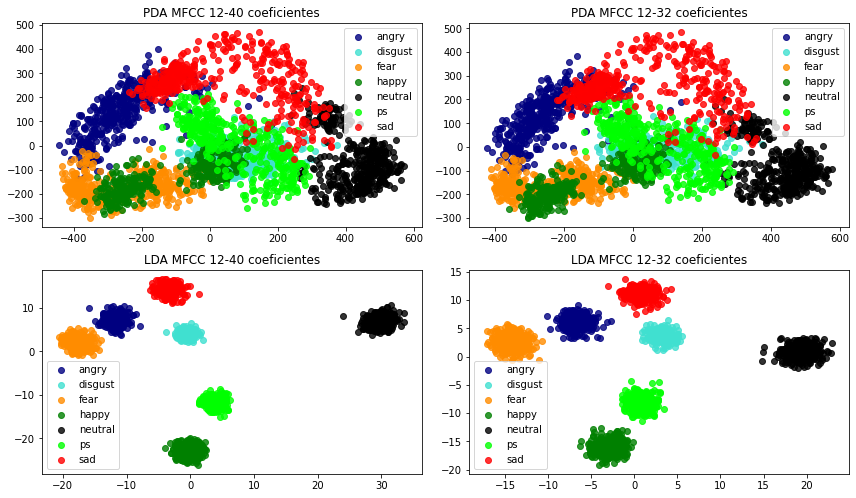

In [327]:
plt.rcParams['figure.figsize'] = [12, 7]

targets = lb.classes_
colors = ['navy', 'turquoise', 'darkorange', 'green', 'black', 'lime', 'red']

plt.subplot(221)
for color, i, targets in zip(colors, [0, 1, 2, 3, 4, 5, 6], targets):
    plt.scatter(X_mfcc_all_pca[y_all_2 == i, 0], X_mfcc_all_pca[y_all_2 == i, 1], alpha=.8, color=color, label=targets)
plt.legend(loc='upper right', shadow=False, scatterpoints=1)
plt.title('PCA MFCC 12-40 coeficientes')

targets = lb.classes_
colors = ['navy', 'turquoise', 'darkorange', 'green', 'black', 'lime', 'red']
plt.subplot(222)
for color, i, targets in zip(colors, [0, 1, 2, 3, 4, 5, 6], targets):
    plt.scatter(X_mfcc_pca_all_smaller[y_all_2 == i, 0], X_mfcc_pca_all_smaller[y_all_2 == i, 1], alpha=.8, color=color, label=targets)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA MFCC 12-32 coeficientes')

targets = lb.classes_
colors = ['navy', 'turquoise', 'darkorange', 'green', 'black', 'lime', 'red']
plt.subplot(223)
for color, i, targets in zip(colors, [0, 1, 2, 3, 4, 5, 6], targets):
    plt.scatter(X_mfcc_all_lda[y_all_2 == i, 0], X_mfcc_all_lda[y_all_2 == i, 1], alpha=.8, color=color, label=targets)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA MFCC 12-40 coeficientes')

targets = lb.classes_
colors = ['navy', 'turquoise', 'darkorange', 'green', 'black', 'lime', 'red']
plt.subplot(224)
for color, i, targets in zip(colors, [0, 1, 2, 3, 4, 5, 6], targets):
    plt.scatter(X_mfcc_lda_all_smaller[y_all_2 == i, 0], X_mfcc_lda_all_smaller[y_all_2 == i, 1], alpha=.8, color=color, label=targets)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA MFCC 12-32 coeficientes')

plt.tight_layout(pad=1.0)

### Comparação usando as 3 componentes principais do PCA/LDA (3D) ###

<IPython.core.display.Javascript object>


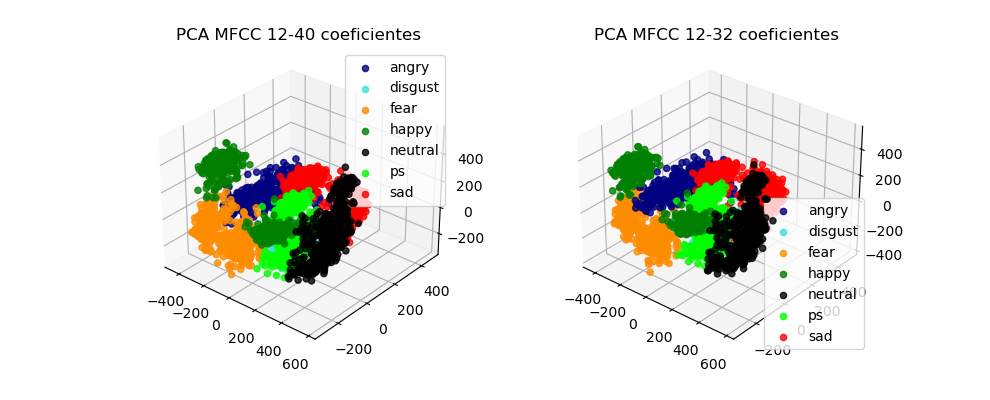

Text(0.5, 0.92, 'PCA MFCC 12-32 coeficientes')

In [59]:
%matplotlib notebook
targets = lb.classes_
colors = ['navy', 'turquoise', 'darkorange', 'green', 'black', 'lime', 'red']

fig = plt.figure(figsize=(9.9,4))
ax = fig.add_subplot(121, projection='3d')

for color, i, targets in zip(colors, [0, 1, 2, 3, 4, 5, 6], targets):
    ax.scatter(X_mfcc_all_pca[y_all_2 == i, 0], X_mfcc_all_pca[y_all_2 == i, 1], X_mfcc_all_pca[y_all_2 == i, 2], 
                alpha=.8, color=color, label=targets)
ax.legend(loc='upper right', shadow=False, scatterpoints=1)
ax.view_init(30, 310)
plt.title('PCA MFCC 12-40 coeficientes')


targets = lb.classes_
colors = ['navy', 'turquoise', 'darkorange', 'green', 'black', 'lime', 'red']
ax = fig.add_subplot(122, projection='3d')

for color, i, targets in zip(colors, [0, 1, 2, 3, 4, 5, 6], targets):
    ax.scatter(X_mfcc_pca_all_smaller[y_all_2 == i, 0], X_mfcc_pca_all_smaller[y_all_2 == i, 1], 
               X_mfcc_pca_all_smaller[y_all_2 == i, 2], alpha=.8, color=color, label=targets)
ax.legend(loc='best', shadow=False, scatterpoints=1)
ax.view_init(30, 310)
plt.title('PCA MFCC 12-32 coeficientes')

#### Colocar modo de plot inline

In [334]:
%matplotlib inline

#### Observação: Usando menos coeficientes a separação dos dados similar contudo resultou numa diminuição dos coeficientes de 28 para 20. 

#### Observa-se ainda que existe muita sobreposição de dados no PCA usando somente os dois principal components.

### Treinar features selecionadas com a rede neuronal ###

In [259]:
# MFCC extraction for dataset
mfccs_data_all = []
for i in tqdm(range(len(dataset))):
        mfccs = librosa.feature.mfcc(dataset[i], sr, n_mfcc=40, fmax=sr//4)
        mfccs_line1 = mfccs[12:33, :] 
        mfccs_data_all.append(mfccs_line1)

100%|██████████████████████████████████████████████████████████| 2800/2800 [00:35<00:00, 79.40it/s]


#### Normalizar dados ####

In [261]:
X_all = np.array(mfccs_data_all)
X_all = np.reshape(X_all, (X_all.shape[0], X_all.shape[1], X_all.shape[2], 1))
print("Image shape: ", X_all.shape)
print("\nImage Max: ", X_all.max().round(1), "\nImage Min: ", X_all.min().round(1))
print("Image Mean: ", X_all.mean().round(1), "\nImage std: ", X_all.std().round(1))

# valores máximos de média e desvio-padrão considerados
Xmean_all = -3
Xstd_all = 13
X_all = (X_all - Xmean_all) / Xstd_all
X_all.mean(), X_all.std()

Image shape:  (2800, 21, 129, 1)

Image Max:  76.9 
Image Min:  -60.6
Image Mean:  -2.5 
Image std:  12.3


(0.03511787439400991, 0.9481943055855729)

#### Codificar labels ####

In [262]:
lb_all = LabelEncoder()
y_cat_all = to_categorical(lb_all.fit_transform(data_y_all))
num_classes = len(lb_all.classes_)
print("classes: ", lb_all.classes_)

classes:  ['angry' 'disgust' 'fear' 'happy' 'neutral' 'ps' 'sad']


#### Repartir dados por treino, validação e teste ####

In [263]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_cat_all, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print(X_train.shape, X_val.shape, X_test.shape)

(1680, 21, 129, 1) (560, 21, 129, 1) (560, 21, 129, 1)


#### Treinar modelo com a CNN anterior ####

In [264]:
model = Sequential([
    Input(shape=(X_all.shape[1], X_all.shape[2], 1)),
    Conv2D(32, 3, activation='relu', padding="same"),
    MaxPooling2D(2, 2, padding='same'),
    Dropout(0.1),
    Conv2D(64, 3, activation='relu', padding="same"),
    MaxPooling2D(2, 2, padding='same'),
    Dropout(0.1),
    Conv2D(64, 3, activation='relu', padding="same"),
    MaxPooling2D(2, 2, padding='same'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(24, activation='relu'),
    Dense(num_classes, activation='softmax'),
])

es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

m_loss = CategoricalCrossentropy(label_smoothing=0.1)
model.compile(optimizer="adam", loss=m_loss, metrics=["accuracy"])

In [265]:
history_all = model.fit(X_train, y_train, epochs=8, validation_data=(X_val, y_val), callbacks=[es])

Train on 1680 samples, validate on 560 samples
Epoch 1/8
1680/1680 [==============================] - 3s 2ms/sample - loss: 1.0990 - accuracy: 0.7036 - val_loss: 0.5934 - val_accuracy: 0.9857
Epoch 2/8
1680/1680 [==============================] - 2s 1ms/sample - loss: 0.6200 - accuracy: 0.9685 - val_loss: 0.5070 - val_accuracy: 0.9964
Epoch 3/8
1680/1680 [==============================] - 2s 1ms/sample - loss: 0.5636 - accuracy: 0.9869 - val_loss: 0.4834 - val_accuracy: 0.9982
Epoch 4/8
1680/1680 [==============================] - 2s 1ms/sample - loss: 0.5265 - accuracy: 0.9964 - val_loss: 0.4733 - val_accuracy: 0.9982
Epoch 5/8
1680/1680 [==============================] - 2s 1ms/sample - loss: 0.5114 - accuracy: 0.9970 - val_loss: 0.4700 - val_accuracy: 0.9982
Epoch 6/8
1680/1680 [==============================] - 2s 1ms/sample - loss: 0.5095 - accuracy: 0.9964 - val_loss: 0.4670 - val_accuracy: 0.9982
Epoch 7/8
1680/1680 [==============================] - 2s 1ms/sample - loss: 0.4965

In [266]:
y_pred = model.predict(X_test)
print("Accuracy of test dataset: ", np.round(accuracy_score(np.argmax(y_pred, axis=1), np.argmax(y_test, axis=1)), 4))

Accuracy of test dataset:  0.9982


#### Learning Curves ####

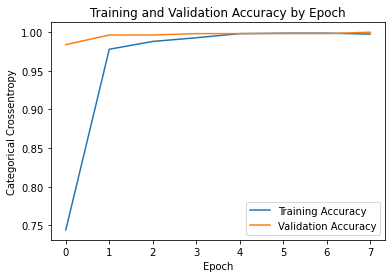

In [240]:
plt.rcParams['figure.figsize'] = [6, 4]
train_accuracy = history_all.history['accuracy']
val_accuracy = history_all.history['val_accuracy']

plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')

plt.title('Training and Validation Accuracy by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Categorical Crossentropy')
plt.legend()
plt.show()

#### Confusion Matrix e Classification Report ####

Classification Report:
              precision    recall  f1-score   support

       angry       1.00      1.00      1.00        88
     disgust       1.00      1.00      1.00        73
        fear       1.00      1.00      1.00        89
       happy       1.00      0.99      0.99        85
     neutral       1.00      1.00      1.00        64
          ps       0.99      1.00      0.99        82
         sad       1.00      1.00      1.00        79

    accuracy                           1.00       560
   macro avg       1.00      1.00      1.00       560
weighted avg       1.00      1.00      1.00       560


Confusion Matrix:


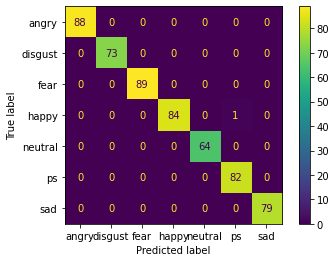

In [268]:
print('Classification Report:')
print(classification_report(np.argmax(y_pred, axis=1), np.argmax(y_test, axis=1), target_names=lb_all.classes_))

cm = confusion_matrix(np.argmax(y_pred, axis=1), np.argmax(y_test, axis=1))
cmd = ConfusionMatrixDisplay(cm, display_labels=lb_all.classes_)
print('\nConfusion Matrix:')
cmd.plot()